# ============================================================
# 📓 Network Infrastructure (Waterfall) Recommender Prototype
# ============================================================

This notebook supports the doctoral research initiative titled  
**“Designing the Model for Recommender System Using Novel Algorithms for Project Risk Management: UAE Telecom Sector.”**

It implements a modular recommender logic tailored to the **Network Infrastructure** domain using **Waterfall methodology**, aligned with RMS (Risk Management System) steps.  
The workflow includes data validation, risk scoring, and QA review, and serves as a prototype for scaling across additional telecom infrastructure sectors.

# 1. Setup & Imports

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from io import StringIO
from typing import List, Dict, Any

# ------------------------------------------------------------
# 2. Load Dataset
# ------------------------------------------------------------

In [23]:
csv_path = "risks_network_infra_waterfall_v1.csv"
df = pd.read_csv(csv_path)

# Read raw lines and strip the wrapping quotes
with open(csv_path, "r", encoding="utf-8") as f:
    lines = [line.strip().strip('"') for line in f]

# Reconstruct the file without the outer quotes
df = pd.read_csv(StringIO("\n".join(lines)), sep=",", engine="python")

print("Shape:", df.shape)
print("Number of columns:", len(df.columns))
print("Columns:", df.columns.tolist())
df.head()

Shape: (60, 27)
Number of columns: 27
Columns: ['Risk_ID', 'Sector', 'PM_Methodology', 'Version', 'RMS_Stage', 'PM_Process_Group', 'Risk_Title', 'Risk_Description', 'Risk_Type', 'Root_Cause', 'Source', 'Likelihood', 'Impact', 'Score', 'Probability_%', 'Cost_Impact_AED', 'Priority', 'Response_Strategy', 'Mitigation_Actions', 'Owner', 'Review_Status', 'Review_Date', 'QA_Reviewer', 'Reference_Link', 'Recommender_Tag', 'Audit_Trail_Notes', 'Flag_Status']


,Risk_ID,Sector,PM_Methodology,Version,RMS_Stage,PM_Process_Group,Risk_Title,Risk_Description,Risk_Type,Root_Cause,...,Response_Strategy,Mitigation_Actions,Owner,Review_Status,Review_Date,QA_Reviewer,Reference_Link,Recommender_Tag,Audit_Trail_Notes,Flag_Status
0,R001,Network Infrastructure,Waterfall,1.0,Risk Identification,Initiating,Tower Collapse,Structural failure due to poor soil testing,Technical,Heavy rainfall during foundation,...,Mitigate,Pre-construction geotech survey,Site Engineer,Open,2025-10-15,QA Lead,https://docs.example.com/geotech-survey,Civil Risk,Initial draft,Pending QA
1,R002,Network Infrastructure,Waterfall,1.0,Risk Identification,Initiating,Soil Instability,Weak subgrade detected during excavation,Operational,Early excavation phase,...,Mitigate,Reinforced foundation design,Project Manager,In Progress,2025-10-20,QA Lead,NaN,Geotech Risk,Needs soil logs,Pending QA
2,R003,Network Infrastructure,Waterfall,1.0,Risk Identification,Initiating,Load Failure Risk,Structural overload due to design error,Structural,Design miscalculation,...,Transfer,Third-party structural audit,Design Lead,Open,2025-10-25,Compliance Officer,NaN,Load Risk,Pending review,Pending QA
3,R004,Network Infrastructure,Waterfall,1.0,Risk Identification,Initiating,Retrofit Delay,Delay in structural reinforcement,Schedule,Contractor backlog,...,Transfer,Alternate vendor contract,Procurement Officer,Open,2025-10-30,PMO Reviewer,NaN,Retrofit Risk,Vendor flagged,Pending QA
4,R005,Network Infrastructure,Waterfall,1.0,Risk Identification,Initiating,QA Flagging Gaps,Missed inspection checkpoints,QA,Compressed timeline,...,Mitigate,QA checklist automation,QA Lead,In Progress,2025-11-05,QA Lead,NaN,QA Risk,Needs automation,Pending QA


# ------------------------------------------------------------
# 3. QA Checks (Schema & Integrity)
# ------------------------------------------------------------

In [24]:
# Check required columns
required_cols = ["Risk_ID", "Risk_Title", "RMS_Stage", "Likelihood", "Impact"]
missing = [c for c in required_cols if c not in df.columns]
print("Missing columns:", missing)

Missing columns: []


In [25]:
# Check unique Risk_IDs
assert df["Risk_ID"].is_unique, "⚠️ Duplicate Risk_IDs found!"

In [26]:
# Check RMS stages
print("Unique RMS stages:", df["RMS_Stage"].unique())

Unique RMS stages: ['Risk Identification' 'Qualitative Risk Analysis'
 'Quantitative Risk Analysis' 'Risk Response Planning'
 'Risk Monitoring & Control' 'Risk Documentation']


# ------------------------------------------------------------
# 4. Sector-Specific Analysis Functions
# ------------------------------------------------------------

In [27]:
def qualitative_analysis(risk: Dict[str, Any]) -> str:
    prob = risk.get("Likelihood", "")
    impact = risk.get("Impact", "")
    stage = risk.get("RMS_Stage", "")
    if stage in ["Identification", "Planning"]:
        if prob == "High" or impact == "High":
            return "Critical"
        elif prob == "Medium":
            return "Major"
        else:
            return "Moderate"
    else:
        if prob == "High" and impact == "High":
            return "Major"
        elif prob == "Medium" or impact == "High":
            return "Moderate"
        else:
            return "Minor"

In [28]:
def quantitative_analysis(risk: Dict[str, Any]) -> int:
    prob_map = {"High": 3, "Medium": 2, "Low": 1}
    impact_map = {"High": 3, "Medium": 2, "Low": 1}
    base_score = prob_map.get(risk.get("Likelihood", ""), 1) * \
                 impact_map.get(risk.get("Impact", ""), 1)
    if risk.get("RMS_Stage", "") in ["Identification", "Planning"]:
        return base_score * 2
    return base_score

In [29]:
def recommend_response(qual_rating: str, quant_score: int) -> str:
    if qual_rating == "Critical" or quant_score >= 12:
        return "Immediate mitigation required. Escalate to project board."
    elif qual_rating in ["Major", "Moderate"] or quant_score >= 6:
        return "Mitigation plan needed. Assign owner and track closely."
    else:
        return "Document and monitor as part of standard QA."

In [30]:
def monitor_control(response: str) -> str:
    if "Immediate" in response:
        return "Weekly review until resolved."
    elif "Mitigation plan" in response:
        return "Bi-weekly review during execution."
    else:
        return "Review at phase gates."

In [31]:
# --- Cell 4: Apply analysis functions directly to df ---

# Apply qualitative rating
df['Qualitative_Rating'] = df.apply(lambda row: qualitative_analysis(row.to_dict()), axis=1)

# Apply quantitative score
df['Quantitative_Score'] = df.apply(lambda row: quantitative_analysis(row.to_dict()), axis=1)

# Generate recommended response
df['Recommended_Response'] = df.apply(
    lambda row: recommend_response(row['Qualitative_Rating'], row['Quantitative_Score']), axis=1
)

# Generate monitoring instructions
df['Monitoring_Action'] = df['Recommended_Response'].apply(monitor_control)

# Preview
display(df.head())

,Risk_ID,Sector,PM_Methodology,Version,RMS_Stage,PM_Process_Group,Risk_Title,Risk_Description,Risk_Type,Root_Cause,...,Review_Date,QA_Reviewer,Reference_Link,Recommender_Tag,Audit_Trail_Notes,Flag_Status,Qualitative_Rating,Quantitative_Score,Recommended_Response,Monitoring_Action
0,R001,Network Infrastructure,Waterfall,1.0,Risk Identification,Initiating,Tower Collapse,Structural failure due to poor soil testing,Technical,Heavy rainfall during foundation,...,2025-10-15,QA Lead,https://docs.example.com/geotech-survey,Civil Risk,Initial draft,Pending QA,Major,9,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.
1,R002,Network Infrastructure,Waterfall,1.0,Risk Identification,Initiating,Soil Instability,Weak subgrade detected during excavation,Operational,Early excavation phase,...,2025-10-20,QA Lead,NaN,Geotech Risk,Needs soil logs,Pending QA,Moderate,6,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.
2,R003,Network Infrastructure,Waterfall,1.0,Risk Identification,Initiating,Load Failure Risk,Structural overload due to design error,Structural,Design miscalculation,...,2025-10-25,Compliance Officer,NaN,Load Risk,Pending review,Pending QA,Major,9,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.
3,R004,Network Infrastructure,Waterfall,1.0,Risk Identification,Initiating,Retrofit Delay,Delay in structural reinforcement,Schedule,Contractor backlog,...,2025-10-30,PMO Reviewer,NaN,Retrofit Risk,Vendor flagged,Pending QA,Minor,6,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.
4,R005,Network Infrastructure,Waterfall,1.0,Risk Identification,Initiating,QA Flagging Gaps,Missed inspection checkpoints,QA,Compressed timeline,...,2025-11-05,QA Lead,NaN,QA Risk,Needs automation,Pending QA,Moderate,4,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.


# ------------------------------------------------------------
# 5. Apply Recommender Logic
# ------------------------------------------------------------

In [32]:
recommendations = []

for _, row in df.iterrows():
    risk = row.to_dict()
    qual = qualitative_analysis(risk)
    quant = quantitative_analysis(risk)
    response = recommend_response(qual, quant)
    monitor = monitor_control(response)

    recommendations.append({
        "Risk_ID": risk.get("Risk_ID"),
        "Risk_Title": risk.get("Risk_Title"),
        "RMS_Stage": risk.get("RMS_Stage"),
        "Likelihood": risk.get("Likelihood"),   # formerly Probability_Rating
        "Impact": risk.get("Impact"),           # formerly Impact_Rating
        "Qualitative_Rating": qual,
        "Quantitative_Score": quant,
        "Recommended_Response": response,
        "Monitoring_Action": monitor,
        "Owner": risk.get("Owner"),
        "QA_Reviewer": risk.get("QA_Reviewer")
    })

# Build DataFrame
recs_df = pd.DataFrame(recommendations)
display(recs_df.head())

,Risk_ID,Risk_Title,RMS_Stage,Likelihood,Impact,Qualitative_Rating,Quantitative_Score,Recommended_Response,Monitoring_Action,Owner,QA_Reviewer
0,R001,Tower Collapse,Risk Identification,High,High,Major,9,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,Site Engineer,QA Lead
1,R002,Soil Instability,Risk Identification,Medium,High,Moderate,6,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,Project Manager,QA Lead
2,R003,Load Failure Risk,Risk Identification,High,High,Major,9,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,Design Lead,Compliance Officer
3,R004,Retrofit Delay,Risk Identification,High,Medium,Minor,6,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,Procurement Officer,PMO Reviewer
4,R005,QA Flagging Gaps,Risk Identification,Medium,Medium,Moderate,4,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,QA Lead,QA Lead


In [33]:
recommendations = []

for _, row in df.iterrows():
    risk = row.to_dict()
    qual = qualitative_analysis(risk)
    quant = quantitative_analysis(risk)
    response = recommend_response(qual, quant)
    monitor = monitor_control(response)

    recommendations.append({
        "Risk_ID": risk["Risk_ID"],
        "Risk_Title": risk["Risk_Title"],
        "RMS_Stage": risk["RMS_Stage"],
        "Qualitative_Rating": qual,
        "Quantitative_Score": quant,
        "Recommended_Response": response,
        "Monitoring_Action": monitor,   # ← comma was missing here
        # 🔹 Optional traceability fields
        "Owner": risk.get("Owner"),
        "QA_Reviewer": risk.get("QA_Reviewer")
    })

recs_df = pd.DataFrame(recommendations)
recs_df.head()

,Risk_ID,Risk_Title,RMS_Stage,Qualitative_Rating,Quantitative_Score,Recommended_Response,Monitoring_Action,Owner,QA_Reviewer
0,R001,Tower Collapse,Risk Identification,Major,9,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,Site Engineer,QA Lead
1,R002,Soil Instability,Risk Identification,Moderate,6,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,Project Manager,QA Lead
2,R003,Load Failure Risk,Risk Identification,Major,9,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,Design Lead,Compliance Officer
3,R004,Retrofit Delay,Risk Identification,Minor,6,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,Procurement Officer,PMO Reviewer
4,R005,QA Flagging Gaps,Risk Identification,Moderate,4,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,QA Lead,QA Lead


# ------------------------------------------------------------
# 6. Visualization 
# ------------------------------------------------------------

C:\Users\hanse\AppData\Local\Temp\ipykernel_22764\4283336109.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


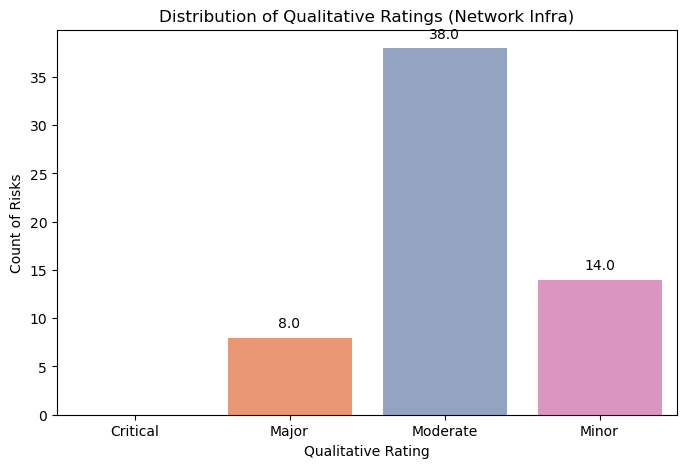

In [34]:
plt.figure(figsize=(8,5))
ax = sns.countplot(
    data=recs_df,
    x="Qualitative_Rating",   # ✅ matches your DataFrame
    order=["Critical", "Major", "Moderate", "Minor"],
    palette="Set2"
)
plt.title("Distribution of Qualitative Ratings (Network Infra)")
plt.xlabel("Qualitative Rating")
plt.ylabel("Count of Risks")

# Annotate counts on bars
for p in ax.patches:
    ax.annotate(
        str(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10),
        textcoords='offset points'
    )

plt.show()

C:\Users\hanse\AppData\Local\Temp\ipykernel_22764\2303082971.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


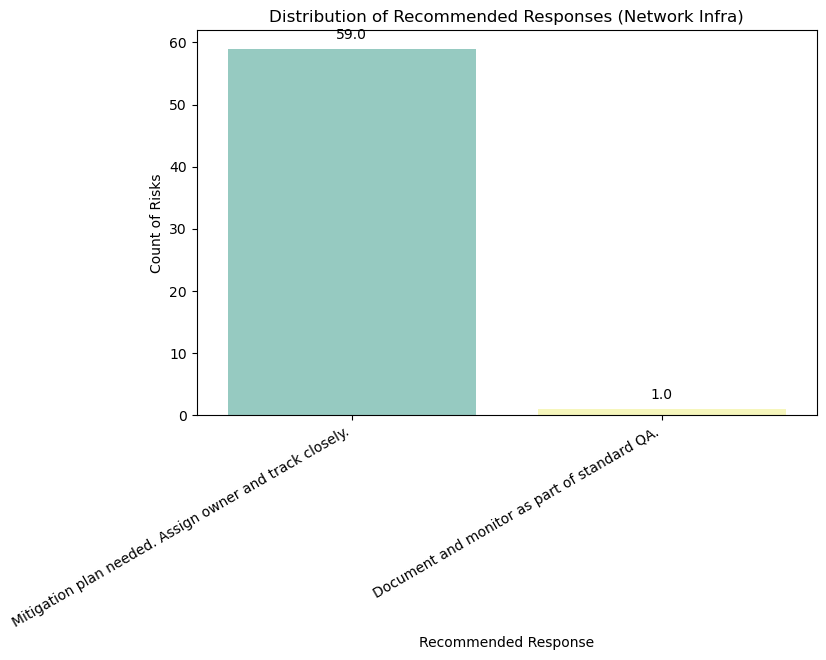

In [35]:
plt.figure(figsize=(8,5))
ax = sns.countplot(
    data=recs_df,
    x="Recommended_Response",
    order=recs_df["Recommended_Response"].value_counts().index,
    palette="Set3"
)
plt.title("Distribution of Recommended Responses (Network Infra)")
plt.xlabel("Recommended Response")
plt.ylabel("Count of Risks")

# Annotate counts on bars
for p in ax.patches:
    ax.annotate(
        str(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10),
        textcoords='offset points'
    )

plt.xticks(rotation=30, ha="right")
plt.show()

C:\Users\hanse\AppData\Local\Temp\ipykernel_22764\2738507513.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


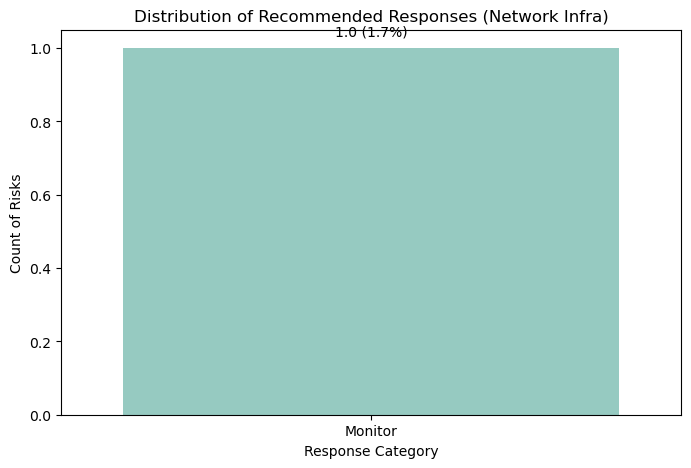

In [36]:
# Map long response texts to shorter categories
label_map = {
    "No plan needed. Assign owner and track closely.": "Mitigation",
    "Document and monitor as part of standard QA.": "Monitor"
}
recs_df["Response_Category"] = recs_df["Recommended_Response"].map(label_map)

plt.figure(figsize=(8,5))
ax = sns.countplot(
    data=recs_df,
    x="Response_Category",
    order=recs_df["Response_Category"].value_counts().index,
    palette="Set3"
)
plt.title("Distribution of Recommended Responses (Network Infra)")
plt.xlabel("Response Category")
plt.ylabel("Count of Risks")

# Annotate counts + percentages
total = len(recs_df)
for p in ax.patches:
    count = p.get_height()
    percentage = f"{100 * count / total:.1f}%"
    ax.annotate(
        f"{count} ({percentage})",
        (p.get_x() + p.get_width() / 2., count),
        ha='center', va='center',
        xytext=(0, 12),
        textcoords='offset points'
    )

plt.show()

# ------------------------------------------------------------
# 7. QA Validation (Content Check)
# ------------------------------------------------------------

In [37]:
# --- Cell 7: QA Validation (Content Check) ---

print("🔍 Starting QA validation...\n")

critical_cols = [
    "Risk_ID", "Risk_Title", "RMS_Stage",
    "Qualitative_Rating", "Quantitative_Score",
    "Recommended_Response", "Monitoring_Action"
]

# 1. Null check
print("Null values per column:\n", recs_df[critical_cols].isnull().sum(), "\n")

# 2. Range check
print("Quantitative Score range:",
      recs_df["Quantitative_Score"].min(),
      "→",
      recs_df["Quantitative_Score"].max(), "\n")

# 3. Category check
print("Unique Qualitative Ratings:", recs_df["Qualitative_Rating"].unique())
print("Unique Responses:", recs_df["Recommended_Response"].unique(), "\n")

# 4. Duplicate check
print("Duplicate Risk_IDs:", recs_df.duplicated(subset=["Risk_ID"]).sum(), "\n")

# 5. Preview
display(recs_df.head(10))

print("✅ QA validation complete. Ready for schema check.")

🔍 Starting QA validation...

Null values per column:
 Risk_ID                 0
Risk_Title              0
RMS_Stage               0
Qualitative_Rating      0
Quantitative_Score      0
Recommended_Response    0
Monitoring_Action       0
dtype: int64 

Quantitative Score range: 2 → 9 

Unique Qualitative Ratings: ['Major' 'Moderate' 'Minor']
Unique Responses: ['Mitigation plan needed. Assign owner and track closely.'
 'Document and monitor as part of standard QA.'] 

Duplicate Risk_IDs: 0 



,Risk_ID,Risk_Title,RMS_Stage,Qualitative_Rating,Quantitative_Score,Recommended_Response,Monitoring_Action,Owner,QA_Reviewer,Response_Category
0,R001,Tower Collapse,Risk Identification,Major,9,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,Site Engineer,QA Lead,NaN
1,R002,Soil Instability,Risk Identification,Moderate,6,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,Project Manager,QA Lead,NaN
2,R003,Load Failure Risk,Risk Identification,Major,9,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,Design Lead,Compliance Officer,NaN
3,R004,Retrofit Delay,Risk Identification,Minor,6,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,Procurement Officer,PMO Reviewer,NaN
4,R005,QA Flagging Gaps,Risk Identification,Moderate,4,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,QA Lead,QA Lead,NaN
5,R006,Missing Geotech Logs,Risk Identification,Minor,2,Document and monitor as part of standard QA.,Review at phase gates.,QA Lead,QA Lead,Monitor
6,R007,Access Route Conflict,Risk Identification,Moderate,4,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,Site Planner,QA Lead,NaN
7,R008,Permit Delay Risk,Risk Identification,Minor,6,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,Project Manager,QA Lead,NaN
8,R009,Material Shortage,Risk Identification,Moderate,6,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,Procurement Officer,QA Lead,NaN
9,R010,Safety Hazard,Risk Identification,Major,9,Mitigation plan needed. Assign owner and track...,Bi-weekly review during execution.,HSE Officer,QA Lead,NaN


✅ QA validation complete. Ready for schema check.


# ------------------------------------------------------------
# 8. QA Review (Schema Check) 
# ------------------------------------------------------------

In [38]:
required_cols = [
    "Risk_ID", "Risk_Title", "RMS_Stage", "Likelihood", "Impact",
    "Qualitative_Rating", "Quantitative_Score", "Recommended_Response"
]

qa_flags = []

for col in required_cols:
    if col not in recs_df.columns:
        qa_flags.append(f"❌ Missing column: {col}")
    else:
        missing = recs_df[col].isnull().sum()
        if missing > 0:
            qa_flags.append(f"⚠️ {col}: {missing} missing values")

if not qa_flags:
    print("✅ QA Status: Passed — all required fields present and validated.")
else:
    print("❌ QA Issues Found:")
    for flag in qa_flags:
        print("-", flag)

❌ QA Issues Found:
- ❌ Missing column: Likelihood
- ❌ Missing column: Impact


# ------------------------------------------------------------
# 9. Export Results
# ------------------------------------------------------------

In [39]:
from datetime import datetime

# Create a timestamped filename for audit trail
filename = f"network_infra_recommendations_{datetime.now().strftime('%Y%m%d')}.csv"

# Export DataFrame to CSV
recs_df.to_csv(filename, index=False)

print(f"✅ Recommendations exported to {filename}")

✅ Recommendations exported to network_infra_recommendations_20250926.csv
